In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

/home/m123/anaconda3/envs/florence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [3]:
np.random.seed(42)

folder_dir = 'data_np/'

mat_files = sorted([file for file in os.listdir(folder_dir) if file.endswith('.npy')])
idx = 5

print(mat_files[idx])

20s_long_heating_refl_50Hz_5J_Tamb_2.npy


In [4]:
image_sequence = np.load(folder_dir + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

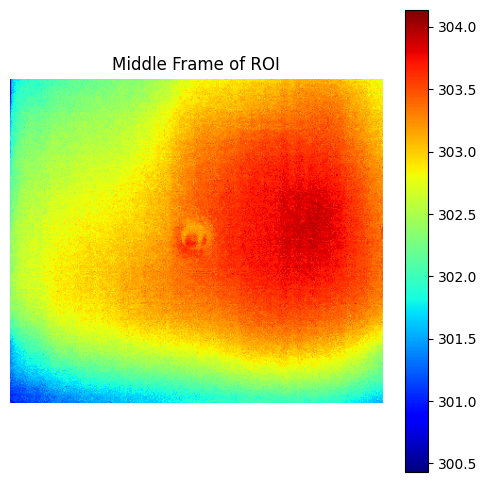

In [5]:
# y1, y2, x1, x2 = 103, 303, 173, 428
# image_sequence = image_sequence[y1:y2, x1:x2, :]

image_sequence = image_sequence[:, 100:495, :]

h, w, t = image_sequence.shape
middle_frame = image_sequence[:, :, t // 2]
plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

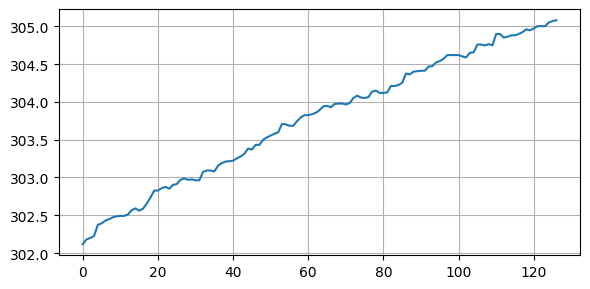

129


In [6]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 88

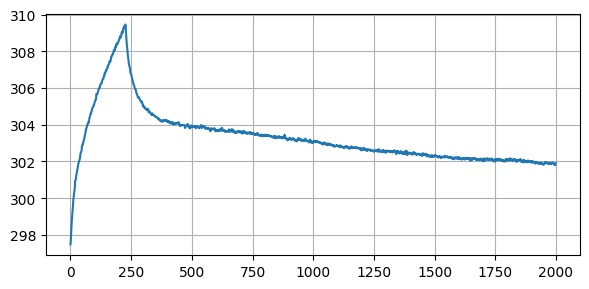

In [7]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

imageMatrix = (imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True))

n_components = 10
latent_dim = n_components

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(imageMatrix)

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class cnn_1d_attention(nn.Module):
    def __init__(self, latent_dim, latent_size):
        super(cnn_1d_attention, self).__init__()

        # Encoding
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding='same')
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding='same')
        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bottleneck
        self.bottleneck = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128, nhead=8, dim_feedforward=512, batch_first=True),
                num_layers=2
            )

        # Decoding
        self.upsample1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding='same')

        self.upsample2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding='same')

        self.upsample3 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding='same')

        self.final_conv = nn.Conv1d(16, 1, kernel_size=1)

        # Positional Encoding
        self.positional_encoding_enc = PositionalEncoding(128)

        # MLP
        self.latent_len = latent_size

        self.mlp_enc = nn.Sequential(
            nn.Linear(128 * self.latent_len, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        self.mlp_dec = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * self.latent_len)
        )


    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        bottleneck_transformer = bottleneck.permute(0, 2, 1)
        bottleneck_transformer = self.positional_encoding_enc(bottleneck_transformer)

        transformer_output = self.transformer_encoder(bottleneck_transformer)

        z_flat = transformer_output.reshape(transformer_output.size(0), -1)
        z = self.mlp_enc(z_flat)

        transformer_recon = self.mlp_dec(z)

        z_recon = transformer_recon.view(transformer_output.size(0), transformer_output.size(1), 128)

        # Decoder
        dec1 = self.upsample1(z_recon.permute(0, 2, 1))
        dec1 = F.relu(self.dec_conv1(dec1))

        dec2 = self.upsample2(dec1)
        dec2 = F.relu(self.dec_conv2(dec2))

        dec3 = self.upsample3(dec2)
        dec3 = F.relu(self.dec_conv3(dec3))

        x_recon = self.final_conv(dec3)

        return x_recon, z, transformer_output, z_recon

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32)

subset_indices = torch.randperm(train_data.shape[0])[:2500]
subset_data = train_data[subset_indices]

pca_data = pca_result[subset_indices]
z_pca_all = torch.tensor(pca_data, dtype=torch.float32, device=device)

subset_data = subset_data.unsqueeze(1).to(device)

dataset = TensorDataset(subset_data, z_pca_all)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

latent_size = imageMatrix.shape[-1] // 8
model = cnn_1d_attention(latent_dim=latent_dim, latent_size=latent_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [11]:
import torch.nn.functional as F

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x, z_pca in dataloader:
        x = x.to(device)
        z_pca = z_pca.to(device)

        optimizer.zero_grad()
        x_recon, z_ae, z, z_recon = model(x)

        loss_recon = F.mse_loss(x_recon, x)
        loss_recon_z = F.mse_loss(z_recon, z)

        loss = loss_recon + 1.0 * loss_recon_z

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

print(f"Epoch {epoch+1}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

Epoch 0: Total Loss = 3.6156 | Recon = 3.5416 | Z = 0.0740
Epoch 10: Total Loss = 0.0224 | Recon = 0.0106 | Z = 0.0118
Epoch 20: Total Loss = 0.0111 | Recon = 0.0065 | Z = 0.0046
Epoch 30: Total Loss = 0.0068 | Recon = 0.0045 | Z = 0.0024
Epoch 40: Total Loss = 0.0058 | Recon = 0.0043 | Z = 0.0015
Epoch 50: Total Loss = 0.0052 | Recon = 0.0038 | Z = 0.0015
Epoch 60: Total Loss = 0.0044 | Recon = 0.0034 | Z = 0.0010
Epoch 70: Total Loss = 0.0057 | Recon = 0.0046 | Z = 0.0010
Epoch 80: Total Loss = 0.0051 | Recon = 0.0041 | Z = 0.0010
Epoch 90: Total Loss = 0.0043 | Recon = 0.0035 | Z = 0.0008
Epoch 100: Total Loss = 0.0043 | Recon = 0.0035 | Z = 0.0008


In [12]:
batch_size = 64

dataset = TensorDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device).unsqueeze(1)
        x_recon, z_ae, z, z_recon = model(x)
        all_latents.append(z_ae.cpu())

principal_comp = torch.cat(all_latents, dim=0).numpy()

In [13]:
pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

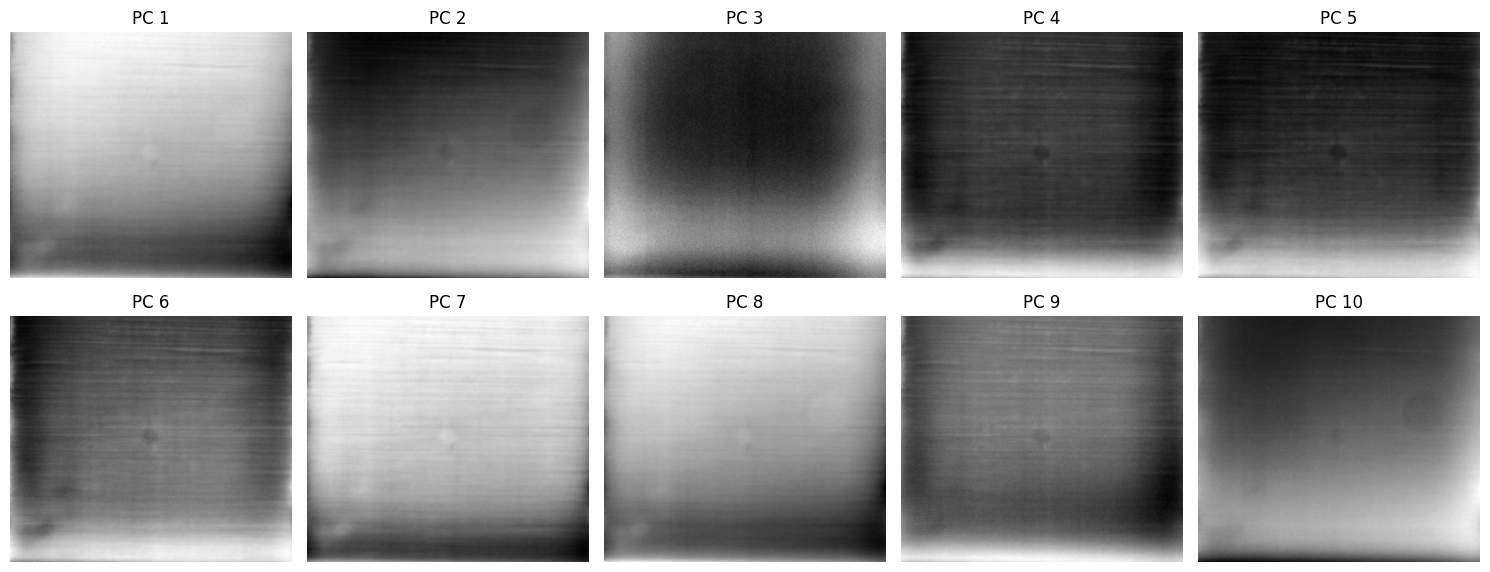

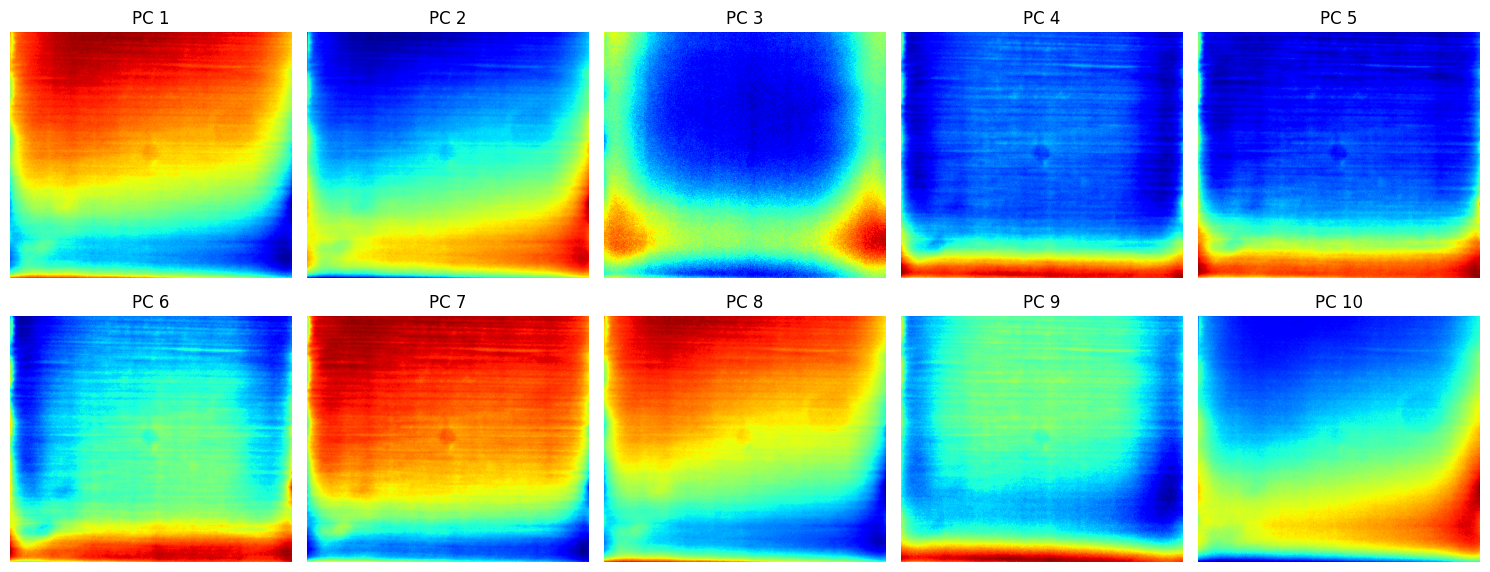

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray') 
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

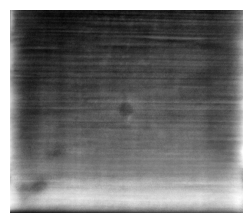

In [23]:
import torch
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

C, H, W = pca_array.shape
flat = pca_array.reshape(C, -1).T

pca = PCA(n_components=1)
pca_result = pca.fit_transform(flat)
comp = pca_result.reshape(H, W)

# comp = np.mean(pca_array, axis=0)
# comp = np.max(pca_array, axis=0)

comp -= comp.min()
comp /= comp.max()

comp = (comp * 255).astype(np.uint8)

gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_8u = clahe.apply(gray_8u)

bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(3, 3))
plt.imshow(img_rgb, cmap='gray')
plt.axis('off')
plt.show()

In [16]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

model_id = "microsoft/Florence-2-large"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True, torch_dtype=dtype
).to(device)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [31]:
from PIL import Image, ImageDraw

image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

save_path = "temp_image.jpg"
image.save(save_path)

In [30]:
def run_example(task_prompt, task_input, image, processor, model, device, dtype):
    if task_input:
        text = task_prompt + task_input
    else:
        text = task_prompt

    inputs = processor(text=text, images=image, return_tensors="pt").to(device, dtype)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=256,
            num_beams=5,
            do_sample=False
        )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed


In [52]:
image = Image.fromarray(img_rgb)

task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
task_input = "hotspot"

results = run_example(task_prompt, task_input, image, processor, model, device, dtype)

In [53]:
draw = ImageDraw.Draw(image)
for box, label in zip(results[task_prompt]["bboxes"], results[task_prompt]["labels"]):
    box = [int(x) for x in box]
    draw.rectangle(box, outline="red", width=3)
    draw.text((box[0], box[1]), label, fill="white")

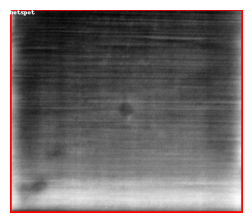

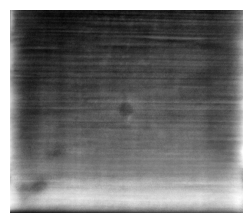

In [54]:
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()